# MCMC Polynomial 3rd order
- Phase Variation = 1st order sinusoid
- Polynomial = 3rd order polynomial

- version 2 of each functions are the latest version (good ones)

In [1]:
'''Import Package'''

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import numpy as np

import scipy
import scipy.stats as sp
import scipy.optimize as spopt

import emcee
import batman
import corner

import time as t
import os

from astropy.table import Table, Column

In [2]:
'''YO THINK ABOUT THIS NORMLIZATION THING'''

def get_data(folderdata):
    path = folderdata + '/ch2_datacube_binned_AORs579.dat'
    #Loading Data
    flux = np.loadtxt(path, usecols=[0], skiprows=1)         # photon count
    flux_err = np.loadtxt(path, usecols=[1], skiprows=1)     # photon count
    time = np.loadtxt(path, usecols=[2], skiprows=1)         # hours
    xdata = np.loadtxt(path, usecols=[4], skiprows=1)        # pixel
    ydata = np.loadtxt(path, usecols=[6], skiprows=1)        # pixel
    psfxwdat = np.loadtxt(path, usecols=[8], skiprows=1)     # pixel
    psfywdat = np.loadtxt(path, usecols=[10], skiprows=1)    # pixel
    # convert time into days
    #hrstodays=1.0/24.0
    #time = hrstodays*time
    # normalized flux (will not agree with model, so allow an offset)
    factor = 1/(np.median(flux))
    flux = factor*flux
    flux_err = factor*flux
    return flux, flux_err, time, xdata, ydata, psfxwdat, psfywdat

def get_data_psf(folderdata):
    # loading data
    photpath1 = folderdata + '/ch2_datacube_binned_AORs579.dat'
    #PSF_popt = folderdata +  '/ch2_datacube_popt_AORs579.dat'
    #PSF_pcov = folderdata + '/ch2_datacube_pcov_AORs579.dat'


    flux = np.loadtxt(photpath1, usecols=[0], skiprows=1)
    flux_err = np.loadtxt(photpath1, usecols=[1], skiprows=1)
    time = np.loadtxt(photpath1, usecols=[2], skiprows=1)
    time_err = np.loadtxt(photpath1, usecols=[3], skiprows=1)
    xdata = np.loadtxt(photpath1, usecols=[4], skiprows=1)
    ydata = np.loadtxt(photpath1, usecols=[6], skiprows=1)
    psfxw = np.loadtxt(photpath1, usecols=[8], skiprows=1)
    psfyw = np.loadtxt(photpath1, usecols=[10], skiprows=1)
    #xo2 = np.loadtxt(photpath1, usecols=[12], skiprows=1)
    #yo2 = np.loadtxt(photpath1, usecols=[14], skiprows=1)
    #psfxw2 = np.loadtxt(photpath1, usecols=[16], skiprows=1)
    #psfyw2 = np.loadtxt(photpath1, usecols=[18], skiprows=1)
    
    # conversion
    # convert time into days
    #hrstodays=1.0/24.0
    #time = hrstodays*time
    # normalized flux (will not agree with model, so allow an offset)
    factor = 1/(np.median(flux))
    flux = factor*flux
    flux_err = factor*flux
    
    return flux, flux_err, time, xdata, ydata, psfxw, psfyw

<class 'numpy.ndarray'>
20.1354876736
1288


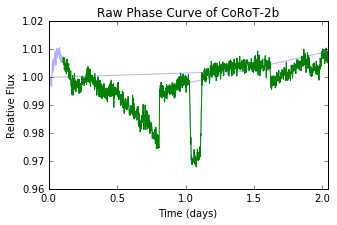

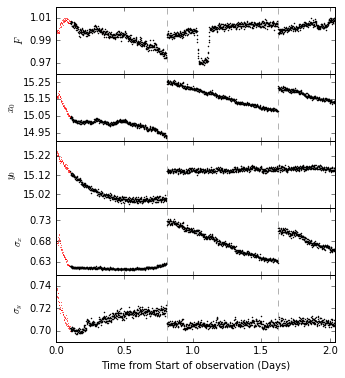

In [3]:
'''Get Data'''
foldername = 'Run4'
flux0, flux_err0, time0, xdata0, ydata0, psfxw0, psfyw0 = get_data_psf(foldername)
flux, flux_err, time, xdata, ydata, psfxw, psfyw = get_data_psf(foldername)

print(type(time))
'''Sort array chronologically'''
index    = np.argsort(time)
time     = time[index]
flux     = flux[index]
flux_err = flux_err[index]
xdata    = xdata[index]
ydata    = ydata[index]
psfxw    = psfxw[index]
psfyw    = psfyw[index]

'''Chop the first 2.5 hours'''

print(np.min(time))
ind = np.where(time>np.min(time)+2.5/24.0)
print(len(flux[ind]))

index    = np.argsort(time)
time     = time[ind]
flux_err = flux_err[ind]
flux     = flux[ind]
xdata    = xdata[ind]
ydata    = ydata[ind]
psfxw    = psfxw[ind]
psfyw    = psfyw[ind]

'''Convert time into BMJD'''
#timeMJD  = Time(time  + 57370.649060411, format = 'mjd', scale = 'utc')
#timeMJD0 = Time(time0 + 57370.649060411, format = 'mjd', scale = 'utc')

#timeJD   = (timeMJD.tdb).jd - 2454833
#timeJD0  = (timeMJD0.tdb).jd - 2454833


'''Convert to orbital phase'''

#timep  = (time-t0_mcmc[0])/per
#timep0 = (time0-t0_mcmc[0])/per

#timeaor1 = (21.75729537037037-t0_mcmc[0])/per
#timeaor2 = (20.94602719907407-t0_mcmc[0])/per

'''Convert time to start of observation'''

start = np.min(time0)

timeaor1 = 21.75729537037037 - np.min(time0)
timeaor2 = 20.94602719907407 - np.min(time0)

time  = time - np.min(time0)
time0 = time0 - np.min(time0)

'''Convert to AOR cuts to start of observation'''

#timep  = (time-t0_mcmc[0])/per
#timep0 = (time0-t0_mcmc[0])/per

#timeaor1 = (21.75729537037037-t0_mcmc[0])/per
#timeaor2 = (20.94602719907407-t0_mcmc[0])/per

'''Plot'''

plt.figure(figsize=(5,3))
plt.plot(time0, flux0, markersize=2, alpha = 0.3)
plt.plot(time, flux, markersize=2)
plt.xlim(np.min(time0), np.max(time0))
plt.title('Raw Phase Curve of CoRoT-2b')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(5, 6))
#fig.suptitle("CoRoT-2b Observation")

axes[0].plot(time0[index], flux0[index],  'r.', markersize=1, alpha = 0.7)
axes[0].plot(time, flux,  'k.', markersize=2, alpha = 1.0)
axes[0].set_ylabel("$F$")
axes[0].set_xlim((np.min(time0), np.max(time0)))
axes[0].set_yticks(np.arange(0.97, 1.01, 0.02))
axes[0].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[0].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[1].plot(time0[index], xdata0[index],  'r.', markersize=1, alpha = 0.7)
axes[1].plot(time, xdata,  'k.', markersize=2, alpha = 1.0)
axes[1].set_ylabel("$x_0$")
axes[1].set_yticks(np.arange(14.95, 15.25, 0.1))
axes[1].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[1].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[2].plot(time0[index], ydata0[index],  'r.', markersize=1, alpha = 0.7)
axes[2].plot(time, ydata, 'k.', markersize=2, alpha = 1.0)
axes[2].set_ylabel("$y_0$")
axes[2].set_yticks(np.arange(15.02, 15.30, 0.1))
axes[2].set_ylim((14.95, 15.3))
axes[2].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[2].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[3].plot(time0[index], psfxw0[index],  'r.', markersize=1, alpha = 0.7)
axes[3].plot(time, psfxw, 'k.', markersize=2, alpha = 1.0)
axes[3].set_ylabel("$\sigma _x$")
axes[3].set_yticks(np.arange(0.63, 0.77, 0.05))
axes[3].set_ylim((0.6, 0.76))
axes[3].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[3].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[4].plot(time0[index], psfyw0[index],  'r.', markersize=1, alpha = 0.7)
axes[4].plot(time, psfyw,  'k.', markersize=2, alpha = 1.0)
axes[4].set_ylabel("$\sigma _y$")
axes[4].set_ylim((0.69, 0.75))
axes[4].set_yticks(np.arange(0.70, 0.74, 0.02))
axes[4].set_xlabel('Time from Start of observation (Days)')
axes[4].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[4].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

fig.subplots_adjust(hspace=0)

#fig.tight_layout()
pathplot1 = foldername + '/MCMC_Poly3_1.pdf'
fig.savefig(pathplot1, bbox_inches='tight')

# Astrophysical Model

- Transit = stellar flux
- $F_p$ = $\Phi (t)$ x $(E(t)-1)$

In [4]:
def phase_variation2(time, t_sec, per, A, B):
    # in this model, we want A+B < 1/sqrt(2) = 0.707
    #t = time - t0 + per/2
    t = time - t_sec
    w = 2*np.pi/per
    phase = 1 + A*(np.cos(w*t)-1) + (B*np.sin(w*t))
    return phase
def transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_secondary = m.get_t_secondary(params)
    return flux, t_secondary

def eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients
    params.fp = fp                                       #planet/star brightnes
    params.t_secondary = t_sec
    #params.t_secondary = params.t0+(params.per/2.0)
    
    m = batman.TransitModel(params, time, transittype="secondary")  #initializes model
    flux = m.light_curve(params)
    return flux

def fplanet_model2(time, A, B, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    phase = phase_variation2(time, t_sec, per, A, B)
    eclip = eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    flux = phase*(eclip - 1)
    return flux

def ideal_lightcurve2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B):
    # retransformation
    ecc = np.sqrt(ecosw**2 + esinw**2)
    w   = np.arctan(esinw/ecosw)
    u1  = 2*np.sqrt(q1)*q2
    u2  = np.sqrt(q1)*(1-2*q2)
    # create transit first and use orbital paramater to get time of superior conjunction
    transit, t_sec = transit_model(time, t0, 1.7429964, rp, a, inc, ecc, w, u1, u2)
    # create light curve of the planet
    fplanet = fplanet_model2(time, A, B, t0, 1.7429964, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    # add both light curves
    f_total = transit + fplanet
    return f_total

In [5]:
'''Check whether phase variation is unphysical'''
'''def check_phase(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B):
    ecc = np.sqrt(ecosw**2 + esinw**2)
    w   = np.arctan(esinw/ecosw)
    u1  = 2*np.sqrt(q1)*q2
    u2  = np.sqrt(q1)*(1-2*q2)
    params = batman.TransitParams()                      #object to store transit parameters
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = 1.7429964                               #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_sec = m.get_t_secondary(params)
    
    phase = phase_variation2(time, t_sec, per, A, B)
    check = any(phase < 0.0)
    return check'''

phi = np.linspace(-np.pi, np.pi, 2000)

def check_phase(F0, C1, D1):
    A0 = F0/2
    A1 = 2*C1/np.pi
    B1 = -2*D1/np.pi
    brit = A0 + A1*np.cos(phi) + B1*np.sin(phi)
    check = any(brit < 0.0)
    return check

# Detector Model and Signal

In [6]:
'''Detector Model'''
def detec_model(xdata, ydata, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, mid_x, mid_y):
    x = xdata - mid_x
    y = ydata - mid_y
    # modeled as 3rd order polynomial
    det_sens = np.array(c1 + c2*x + c3*y + c4*x**2 + c5*x*y  + c6*y**2 
                        + c7*x**3 + c8*y*x**2 + c9*x*y**2 + c10*y**3)    
    return np.array(det_sens)

'''Signal_Model'''
def signal(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, a1, a2, t1, t2,
          xdata, ydata, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, mid_x, mid_y):
    lcurve = ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, a1, a2, t1, t2)
    det = detec_model(xdata, ydata, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, mid_x, mid_y)
    return lcurve*det

def signal2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B,
          xdata, ydata, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, mid_x, mid_y):
    lcurve = ideal_lightcurve2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)
    det = detec_model(xdata, ydata, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, mid_x, mid_y)
    return lcurve*det

In [7]:
'''Initialize parameters'''

# Some variable def
r_star            = 0.902              # solar radius
r_sol2jup         = 0.10045            # jupiter radius in solar radius
r_sol2AU          = 214.93946938       # AU radius in solar radius
hrs2days          = 1/24.0             # hour in days

# Transit Parameters from Gillon 2010 (10 params)
t0   = 21.209872393868476 - start       # initially in hrs
per  = 1.7429964                        # initially in days
rp   = 0.1687756075160066               # initially in jupiter radius
a    = 6.687713016046277                # initially in AU
inc  = 87.8860479918158
ecosw= -4.173007751656632e-06           # dimensionless [0,1]                   
esinw= 1.592689925583807e-06
q1   = 0.017858483791166696
q2   = 0.22208652447845828
fp   = 0.004365292154849771             # eclipse depth in units of stellar flux

# Phase Variation Parameters (2 params)
A    = 0.4312745
B    = 0.2744678

# Detector initial parameters (10 params)
c1   = 1.0043989197456586              # 1
c2   = 0.0063581416590708945           # x
c3   = 0.012378872692283657            # y
c4   = -0.568354339280786              # x^2
c5   = -0.2693084168344859             # xy
c6   = -0.412313143686819              # y^2
c7   = 0.7154570090628998              # x^3
c8   = -4.317867444646165              # x^2y
c9   = 8.38549639142474                # xy^2
c10  = -3.979235261965191              # y^3
sigF =  0.001458409572

# pre-calculation
mid_x = np.mean(xdata)
mid_y = np.mean(ydata)

# Regroup into arrays
p0_astro = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp])
p0_phase = np.array([A, B])
p0_detec = np.array([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
#p0_phase = np.array([a1, a2, t1, t2])

# params only 
#p0 = np.array([t0, per, rp, a, inc, ecc, w, u1, u2, fp,a1, a2, t1, t2, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
p0 = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF])

In [8]:
'''Load Best fit from lower order'''

Result_MCMC = np.load('Run4/no_negative_B/ResultMCMC_Poly3_Params.npy')

'''Initialize parameters'''

# Transit Parameters from Gillon 2010 (10 params)
t0   = Result_MCMC['t0'][0,0] - start # initially in hrs
per  = 1.7429964                      # initially in days
rp   = Result_MCMC['rp'][0,0]         # initially in jupiter radius
a    = Result_MCMC['a'][0,0]          # initially in AU
inc  = Result_MCMC['inc'][0,0]
ecosw= Result_MCMC['ecosw'][0,0]      # dimensionless [0,1]                   
esinw= Result_MCMC['esinw'][0,0]
q1   = Result_MCMC['q1'][0,0]
q2   = Result_MCMC['q2'][0,0]
fp   = Result_MCMC['fp'][0,0]

# Phase Variation Parameters (2 params)
A    = 0.3
B    = 0.3

# Detector initial parameters (10 params)
c1   = Result_MCMC['c1'][0,0]          # 1
c2   = Result_MCMC['c2'][0,0]          # x
c3   = Result_MCMC['c3'][0,0]          # y
c4   = Result_MCMC['c4'][0,0]          # x^2
c5   = Result_MCMC['c5'][0,0]          # xy
c6   = Result_MCMC['c6'][0,0]          # y^2
c7   = Result_MCMC['c7'][0,0]          # x^3
c8   = Result_MCMC['c8'][0,0]          # x^2y
c9   = Result_MCMC['c9'][0,0]          # xy^2
c10  = Result_MCMC['c10'][0,0]          # y^3

# uncertainty
sigF = Result_MCMC['sigF'][0,0]

# pre-calculation
mid_x = np.mean(xdata)
mid_y = np.mean(ydata)

# Regroup into arrays
p0_astro = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp])
p0_phase = np.array([A, B])
p0_detec = np.array([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
#p0_phase = np.array([a1, a2, t1, t2])

# params only 
#p0 = np.array([t0, per, rp, a, inc, ecc, w, u1, u2, fp,a1, a2, t1, t2, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
p0 = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF])

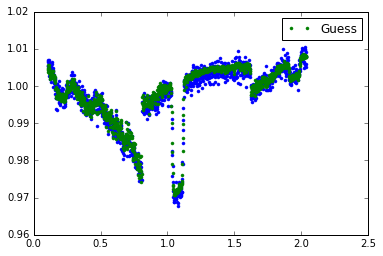

In [9]:
signaltest = signal2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, xdata, ydata, c1, c2, c3, c4, c5, c6,
                    c7, c8, c9, c10,mid_x, mid_y)

plt.figure()
plt.plot(time, flux, '.')
plt.plot(time, signaltest, '.', label = 'Guess')
plt.legend()

In [10]:
'''Detector model definition curve_fit friendly'''
def det4fit(coord, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10):
    xdata, ydata = coord
    mid_x = np.mean(xdata)
    mid_y = np.mean(ydata)    
    x = xdata - mid_x
    y = ydata - mid_y
    # modeled as 3rd order polynomial
    det_sens = np.array(c1 + c2*x + c3*y + c4*x**2 + c5*x*y  + c6*y**2 
                        + c7*x**3 + c8*y*x**2 + c9*x*y**2 + c10*y**3)    
    return np.array(det_sens)

'''Optimization to guess polynomial parameters'''

def fit_residual2(flux, time, xdata, ydata, p0_astro, p0_phase, p0_detec, u_detec, l_detec):
    # Using Gillon 2010 light curve parameters
    t0, rp, a, inc, ecosw, esinw, q1, q2, fp = p0_astro
    A, B = p0_phase
    lcurve = ideal_lightcurve2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)
    # Get residuals
    residuals = flux/lcurve
    # Fit residual
    coord = (xdata, ydata)
    popt, pcov = spopt.curve_fit(det4fit, coord, residuals, p0=p0_detec, bounds = (l_detec, u_detec))
    return popt

# Get initial guess for detector parameters

[  1.00368703e+00  -2.42305136e-03   1.60343511e-02  -5.65874639e-01
  -2.33219298e-01  -3.33608545e-01   8.11488287e-01  -4.69251522e+00
   1.04299273e+01  -4.61088618e+00]


(0.10480896990740973, 2.0372786458333323)

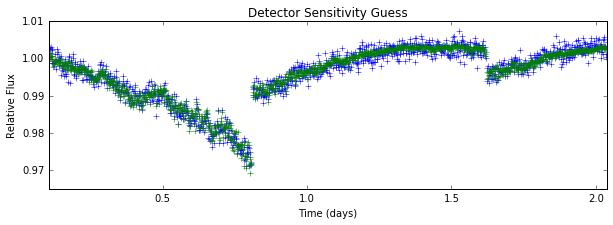

In [11]:
'''Adjust initial parameters'''

# fitting the residuals to get better polynomial guess
u_detec = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
l_detec = [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
p_detec = fit_residual2(flux, time, xdata, ydata, p0_astro, 
                        p0_phase, p0_detec, u_detec, l_detec)
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = p_detec

G = ideal_lightcurve2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)
D = detec_model(xdata, ydata, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, mid_x, mid_y)

print(p_detec)

# update p0
#p0 = np.array([t0, per, rp, a, inc, ecc, w, u1, u2, fp,a1, a2, t1, t2, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
p0 = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, 
               c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF])

plt.figure(figsize=(10,3))
#plt.plot(time, flux)
plt.plot(time, flux/G, '+')
plt.plot(time, D, '+')
plt.title('Detector Sensitivity Guess')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.xlim(np.min(time), np.max(time))

# Likelihood function

In [14]:
'''Log likelihood function'''
def lnlike2(p0, time, flux, xdata, ydata, mid_x, mid_y):
    # unpack p0
    t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, flux_err = p0
    # define model
    model = signal2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, 
                   xdata, ydata, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, mid_x, mid_y)
    inv_sigma2 = 1.0/(flux_err**2)
    return -0.5*(np.sum((flux-model)**2*inv_sigma2) - len(flux)*np.log(inv_sigma2))

'''Probability distribution to draw sample from'''
def lnprior2(p0):
    t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, flux_err = p0
    check = check_phase(1-A, A, B)
    # gaussian prior for a
    lgpri_a = -0.5*(((a - 6.70)/0.03)**2.0)
    # gaussian prior for i
    lgpri_i = -0.5*(((inc - 87.84)/0.1)**2.0)
    # gaussian prior for ecosw
    #lgpri_ecosw = -0.5*(((ecosw + 0.00291)/0.00063)**2.0)
    # gaussian prior for esinw
    #lgpri_esinw = -0.5*(((esinw -  0.0139)/0.0084 )**2.0)
    # uniform prior for the rest
    if (1.05 < t0 < 1.1 and 0 < rp < 1  and 0 < fp < 1 and 
        0 < q1 < 1 and 0 < q2 < 1 and 
        -1 < ecosw < 1 and -1 < esinw < 1 and check == False):
        return 0.0 + lgpri_a + lgpri_i #+ lgpri_ecosw + lgpri_esinw
    return -np.inf

'''Total probability function'''
def lnprob2(p0, time, flux, xdata, ydata, mid_x, mid_y):
    lp = lnprior2(p0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(p0, time, flux, xdata, ydata, mid_x, mid_y)

In [15]:
'''Getting ready for MCMC'''
# total nb steps
totalsteps = 0
# instruction for sampling
ndim, nwalkers, nstep = len(p0), 300, 4000
# get scattered starting point in parameter space 
pos = [p0 + 10**(-5)*np.random.randn(ndim) for i in range(nwalkers)]
#sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, 
                                args=(time, flux, xdata, ydata, mid_x, mid_y))

# Running MCMC

In [16]:
'''Running MCMC'''
print("Running MCMC...")
tic = t.clock()
pos, prob, state = sampler.run_mcmc(pos, nstep)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)
totalsteps += nstep

Running MCMC...
Done.
time taken: 
1670.8923450206146


In [43]:
nstep = 1000
print("Running MCMC...")
tic = t.clock()
pos, prob, state = sampler.run_mcmc(pos, nstep, rstate0=state)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)
totalsteps += nstep

Running MCMC...
Done.
time taken: 
465.8049875449933


In [49]:
print("Running MCMC...")
tic = t.clock()
pos4, prob4, state4 = sampler.run_mcmc(pos3, 1000, rstate0=state3)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)
totalsteps += nstep

Running MCMC...


C:\Users\Lisa\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Lisa\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


Done.
time taken: 
890.0321623801974


In [60]:
print("Running MCMC...")
tic = t.clock()
pos5, prob5, state5 = sampler.run_mcmc(pos4, 1000, rstate0=state4)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)
totalsteps += nstep

Running MCMC...


C:\Users\Lisa\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Lisa\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


Done.
time taken: 
701.0108374576357


# Saving MCMC Results

In [44]:
pathchain = foldername + '/samplerchainPoly3.npy'
pathposit = foldername + '/samplerposi_Poly3.npy'
pathstate = foldername + '/samplerstatePoly3.npy'
np.save(pathchain, sampler.chain[:,-2000:,:])
np.save(pathposit, pos)
#np.save(pathstate, state)

In [45]:
'''print the results'''
samples = sampler.chain[:,-2000:,:].reshape((-1, ndim))
(t0_mcmc, rp_mcmc, a_mcmc, inc_mcmc, ecosw_mcmc, 
 esinw_mcmc, q1_mcmc, q2_mcmc, fp_mcmc, A_mcmc, B_mcmc, 
 c1_mcmc, c2_mcmc, c3_mcmc, c4_mcmc, c5_mcmc, c6_mcmc, c7_mcmc, c8_mcmc, 
 c9_mcmc, c10_mcmc, sigF_mcmc) = map(
    lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

print("""MCMC result:

    t0  = {0[0]} +{0[1]} -{0[2]} (Guess: {1})
    rp  = {2[0]} +{2[1]} -{2[2]} (Gillon: {3})
    a   = {4[0]} +{4[1]} -{4[2]} (Gillon: {5})
    inc = {6[0]} +{6[1]} -{6[2]} (Gillon: {7})
    ecosw = {8[0]} +{8[1]} -{8[2]} (Guess: {9})
    esinw = {10[0]} +{10[1]} -{10[2]} (Gillon: {11})
    q1  = {12[0]} +{12[1]} -{12[2]} (Gillon: {13})
    q2  = {14[0]} +{14[1]} -{14[2]} (Guess: {15})
    fp  = {16[0]} +{16[1]} -{16[2]} (Guess: {17})
    
    A   = {18[0]} +{18[1]} -{18[2]} (Guess: {19})
    B   = {20[0]} +{20[1]} -{20[2]} (Guess: {21})
    
    c1  = {22[0]} +{22[1]} -{22[2]} (Guess: {23})
    c2 = {24[0]} +{24[1]} -{24[2]} (Guess: {25})
    c3 = {26[0]} +{26[1]} -{26[2]} (Guess: {27})
    c4 = {28[0]} +{28[1]} -{28[2]} (Guess: {29})
    c5 = {30[0]} +{30[1]} -{30[2]} (Guess: {31})
    c6 = {32[0]} +{32[1]} -{32[2]} (Guess: {33})
    c7 = {34[0]} +{34[1]} -{34[2]} (Guess: {35})
    c8 = {36[0]} +{36[1]} -{36[2]} (Guess: {37})
    c9 = {38[0]} +{38[1]} -{38[2]} (Guess: {39})
    c10 = {40[0]} +{40[1]} -{40[2]} (Guess: {41})
    sigF = {42[0]} +{42[1]} -{42[2]} (Guess: {43})
    
""".format(t0_mcmc, t0, rp_mcmc, rp, a_mcmc, a, inc_mcmc, inc, 
           ecosw_mcmc, ecosw, esinw_mcmc, esinw, q1_mcmc, q1, q2_mcmc, q2, fp_mcmc, fp,
           A_mcmc, A, B_mcmc, B, c1_mcmc, c1,
           c2_mcmc, c2, c3_mcmc, c3, c4_mcmc, c4, c5_mcmc, c5, c6_mcmc, c6,
           c7_mcmc, c7, c8_mcmc, c8, c9_mcmc, c9, c10_mcmc, c10, sigF_mcmc, sigF))

MCMC result:

    t0  = 1.0743958423087547 +0.00016743884789138797 -0.00016809064260603357 (Guess: 1.0743903820887084)
    rp  = 0.16916579366501328 +0.0009019943096659211 -0.0009529553525810808 (Gillon: 0.16888839922394555)
    a   = 6.684847415449537 +0.024833870848010697 -0.02465441476099617 (Gillon: 6.6835612420032415)
    inc = 87.86394842102538 +0.09185311661870799 -0.08966479643346759 (Gillon: 87.86978501389899)
    ecosw = 1.0254233590124535e-05 +0.00036538798979935565 -0.00035497817244291063 (Guess: -6.641580542677834e-06)
    esinw = -5.075351658202288e-06 +0.00033362771642457507 -0.00033407592625192366 (Gillon: 2.7064614556671866e-06)
    q1  = 0.012900571510717723 +0.01885046099755621 -0.008714261971729946 (Gillon: 0.01394853370037373)
    q2  = 0.3071162929304354 +0.3943371164539393 -0.22797532996974046 (Guess: 0.29385465768597463)
    fp  = 0.004559445034950774 +0.00016504190685385361 -0.000164212080165203 (Guess: 0.004337484617391054)
    
    A   = 0.3921479755842246 +0

In [46]:
def walk_style(ndim, nwalk, samples, interv, subsamp, labels):
    '''
    input:
        ndim    = number of free parameters
        nwalk   = number of walkers
        samples = samples chain
        interv  = take every 'interv' element to thin out the plot
        subsamp = only show the last 'subsamp' steps
    '''
    # get first index
    beg   = len(samples[0,:,0]) - subsamp
    end   = len(samples[0,:,0]) 
    step  = np.arange(beg,end)
    step  = step[::interv] 
    
    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows
    
    # plotting
    #plt.subplot(nrows, ncols, ind)
    #fig.tight_layout()
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        # get indices for subplots
        #i = int(ind/ncols) # row number
        #j = ind % ncols    # col number
        # get mean and standard deviation
        mu_param = np.mean(samples[:,:,ind][:,beg:end:interv], axis = 0)
        std_param = np.std(samples[:,:,ind][:,beg:end:interv], axis = 0)
        plt.plot(step, mu_param)
        plt.fill_between(step, mu_param + 3*std_param, mu_param - 3*std_param, facecolor='k', alpha = 0.1)
        plt.fill_between(step, mu_param + 2*std_param, mu_param - 2*std_param, facecolor='k', alpha = 0.1)
        plt.fill_between(step, mu_param + 1*std_param, mu_param - 1*std_param, facecolor='k', alpha = 0.1)
        plt.title(labels[ind])
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else: 
            plt.xticks(rotation=25)
    return    

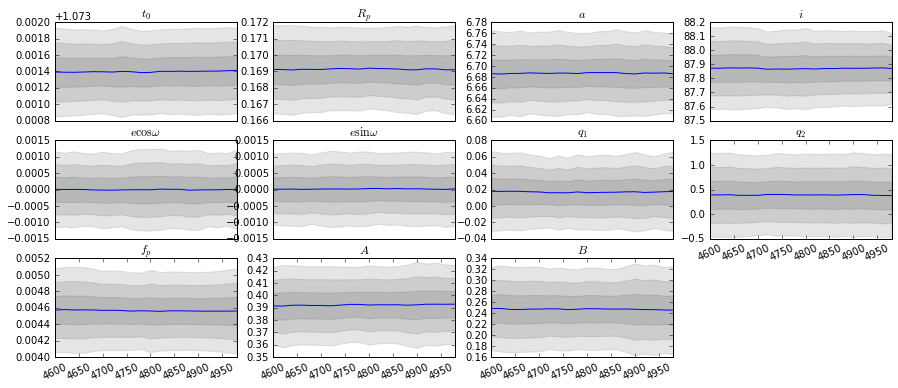

In [47]:
labels = np.array(['$t_0$','$R_p$','$a$','$i$','$e\cos \omega$', '$e \sin \omega$',
                     '$q_1$',r'$q_2$','$f_p$', '$A$', '$B$'], dtype='object_')

walk_style(11, nwalkers, sampler.chain, 20, 400, labels)

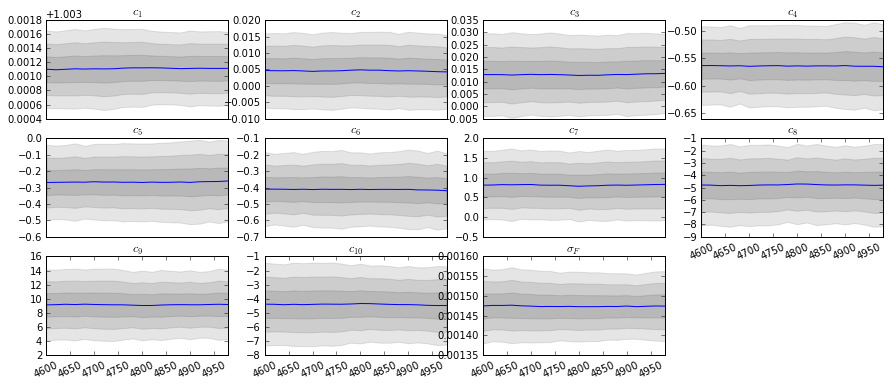

In [48]:
labels = np.array(['$c_1$', '$c_2$', '$c_3$', '$c_4$', '$c_5$',
                   '$c_6$', '$c_7$', '$c_8$', '$c_9$', '$c_{10}$', '$\sigma _F$'], dtype='object_')

walk_style(11, nwalkers, sampler.chain[:,:,11:], 20, 400, labels)

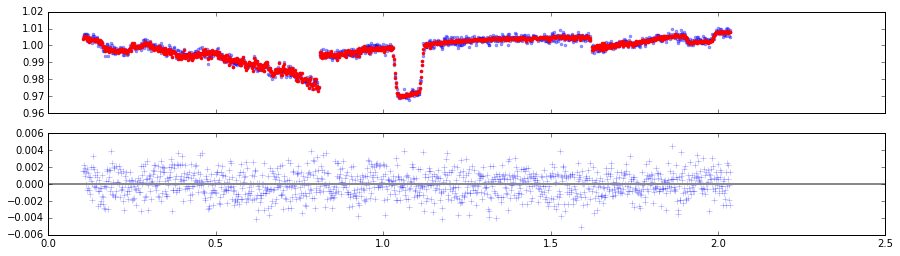

In [49]:
'''signal_result = signal(time, t0_mcmc[0], per_mcmc[0], rp_mcmc[0], a_mcmc[0], inc_mcmc[0], ecc_mcmc[0], 
                       w_mcmc[0], u1_mcmc[0], u2_mcmc[0], fp_mcmc[0], a1_mcmc[0], a2_mcmc[0], t1_mcmc[0], 
                       t2_mcmc[0], xdata, ydata, c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                       c6_mcmc[0], c7_mcmc[0], c8_mcmc[0], c9_mcmc[0], c10_mcmc[0], mid_x, mid_y)'''

signal_result = signal2(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], inc_mcmc[0], ecosw_mcmc[0], 
                        esinw_mcmc[0], q1_mcmc[0], q2_mcmc[0], fp_mcmc[0], A_mcmc[0], B_mcmc[0],
                        xdata, ydata, c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                        c6_mcmc[0], c7_mcmc[0], c8_mcmc[0], c9_mcmc[0], c10_mcmc[0], mid_x, mid_y)

fig, axes = plt.subplots(ncols = 1, nrows = 2, sharex = True,figsize=(15,4))
axes[0].plot(time, flux, 'b.', alpha = 0.4)
axes[0].plot(time, signal_result, 'r.')
axes[1].plot(time, flux - signal_result, '+', alpha = 0.4)
axes[1].axhline(y=0, color="#888888", lw=2)

In [50]:
time2 = np.linspace(np.min(time), np.max(time), 1000)
res_det = detec_model(xdata, ydata, c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                      c6_mcmc[0], c7_mcmc[0], c8_mcmc[0], c9_mcmc[0], c10_mcmc[0], mid_x, mid_y)
res_lightplot = ideal_lightcurve2(time2, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], 
                                   inc_mcmc[0],  ecosw_mcmc[0], esinw_mcmc[0], 
                                  q1_mcmc[0], q2_mcmc[0], 
                                   fp_mcmc[0], A_mcmc[0], B_mcmc[0])
res_lightcurve = ideal_lightcurve2(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], 
                                   inc_mcmc[0],  ecosw_mcmc[0], 
                        esinw_mcmc[0], q1_mcmc[0], q2_mcmc[0], 
                                   fp_mcmc[0], A_mcmc[0], B_mcmc[0])

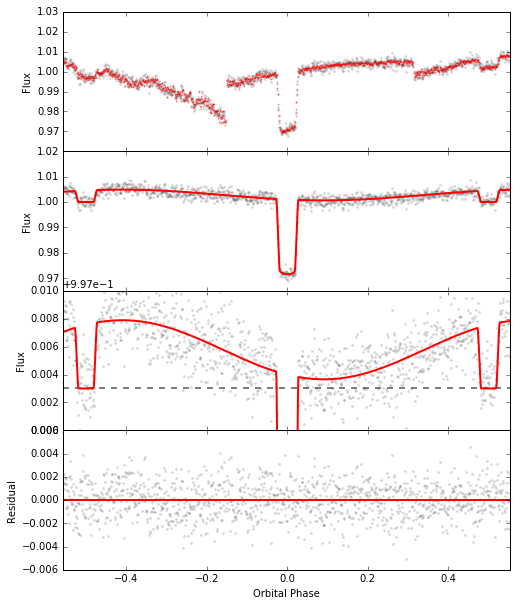

In [51]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 10))
axes[0].set_xlim((np.min(time)-t0_mcmc[0])/per, (np.max(time)-t0_mcmc[0])/per)
axes[0].plot((time-t0_mcmc[0])/per, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[0].plot((time-t0_mcmc[0])/per, res_lightcurve*res_det, '.', color = 'r', markersize = 2.5, alpha = 0.4)
axes[0].set_yticks(np.arange(0.97, 1.03, 0.01))
axes[0].set_ylabel('Flux')

axes[1].plot((time-t0_mcmc[0])/per, flux/res_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[1].plot((time2-t0_mcmc[0])/per, res_lightplot, color = 'r', linewidth=2)
axes[1].set_yticks(np.arange(0.97, 1.02, 0.01))
axes[1].set_ylabel('Flux')
#axes[1].set_ylim(0.995, 1.005)
#axes[1].axhline(y=1, color='b')
#axes[1].axhline(y=1+0.004231819514801176, color='b')
axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
axes[2].plot((time-t0_mcmc[0])/per, flux/res_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[2].plot((time2-t0_mcmc[0])/per, res_lightplot, color = 'r', linewidth=2)
axes[2].set_yticks(np.arange(0.997, 1.008, 0.002))
axes[2].set_ylabel('Flux')
axes[2].set_ylim(0.997, 1.007)

axes[3].plot((time-t0_mcmc[0])/per, flux/res_det - res_lightcurve, 'k.', markersize = 4, alpha = 0.15)
axes[3].axhline(y=0, color='r', linewidth = 2)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Orbital Phase')


fig.subplots_adjust(hspace=0)
plotname = foldername + '/MCMC_Poly3_2.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [52]:
def chi2(data, fit, err):
    N     = len(data)
    denom = (data - fit)**2
    numer = err**2
    chi2  = np.sum(denom/numer)
    return chi2

def loglikelihood(data, fit, err):
    inv_sigma2 = 1.0/(err**2)
    return -0.5*(np.sum((data-fit)**2*inv_sigma2 - np.log(inv_sigma2)))

def BIC(logL, Npar, Ndat):
    E = logL - (Npar/2)*np.log(Ndat)
    return E


ferr_fit = np.ones(len(flux))* sigF_mcmc[0]

data = (flux/res_det)
fit  = res_lightcurve
chisB = chi2(data, fit, ferr_fit)

print(chisB)
logLB = loglikelihood(data, fit, ferr_fit)
print('Likelihood: ',logLB)
EB = BIC(logLB, ndim, len(data))
print('Evidence: ',EB)

1278.6905967
Likelihood:  7758.25344059
Evidence:  7679.48413562


In [53]:
from astropy.stats import sigma_clip

def chi2(data, fit, err):
    N     = len(data)
    denom = (data - fit)**2
    numer = err**2
    chi2  = np.sum(denom/numer)
    return chi2

def loglikelihood(data, fit, err):
    inv_sigma2 = 1.0/(err**2)
    return -0.5*(np.sum((data-fit)**2*inv_sigma2 - np.log(inv_sigma2)))

def BIC(logL, Npar, Ndat):
    E = logL - (Npar/2)*np.log(Ndat)
    return E

def get_full_data(folderdata):
    path = folderdata + '/ch2_datacube_full_AORs579.dat'
    #Loading Data
    flux  = np.loadtxt(path, usecols=[0], skiprows=1)         # photon count
    flux_err = np.loadtxt(path, usecols=[1], skiprows=1)     # photon count
    time  = np.loadtxt(path, usecols=[2], skiprows=1)         # hours
    xdata = np.loadtxt(path, usecols=[3], skiprows=1)         # hours
    ydata = np.loadtxt(path, usecols=[4], skiprows=1)         # hours
    # scaling
    #factor = 1/(np.median(flux))
    #flux = factor*flux
    #flux_err = factor*flux
    return flux, flux_err, time, xdata, ydata
    
    
'''Full Data'''
flux_full, ferr_full, time_full, x_full, y_full = get_full_data(foldername)

time_full = time_full - start

'''Order in chronological order'''
index = np.argsort(time_full)
flux_full = flux_full[index]
ferr_full = ferr_full[index]
time_full = time_full[index]
x_full    = x_full[index]
y_full    = y_full[index]

'''crop the first 2.5 hours'''
index = np.argsort(time_full)
flux_full = flux_full[70*64:]
ferr_full = ferr_full[70*64:]
time_full = time_full[70*64:]
x_full    = x_full[70*64:]
y_full    = y_full[70*64:]

'''Sigma clip per data cube'''
flux_clean = []
x_clean    = []
y_clean    = []

for i in range(1288):
    beg = int(i*64)
    end = int((i+1)*64)
    flux_clean = np.ma.append(flux_clean, sigma_clip(flux_full[beg:end]))
    x_clean = np.ma.append(x_clean, sigma_clip(x_full[beg:end]))
    y_clean = np.ma.append(y_clean, sigma_clip(y_full[beg:end]))

'''Normalize flux'''
flux_clean = flux_clean/np.ma.median(flux_clean)

'''Get model'''
det_full = detec_model(x_clean, y_clean, c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                      c6_mcmc[0], c7_mcmc[0], c8_mcmc[0], c9_mcmc[0], c10_mcmc[0], mid_x, mid_y)
# properly remove centroid outliers
det_full = np.ma.masked_array(det_full, mask=(y_clean.mask+x_clean.mask))

lc_full  = ideal_lightcurve2(time_full, t0_mcmc[0], rp_mcmc[0], a_mcmc[0],
                             inc_mcmc[0], ecosw_mcmc[0], esinw_mcmc[0], q1_mcmc[0], 
                             q2_mcmc[0], fp_mcmc[0], A_mcmc[0], B_mcmc[0])

model_full = det_full*lc_full

'''Get Fitted Uncertainty'''
ferr_clean = np.ones(len(flux_clean))*sigF_mcmc[0]*np.sqrt(64)
ferr_clean = np.ma.masked_array(ferr_clean, mask = model_full.mask)

N = len(model_full)-np.sum((model_full).mask)

chis = chi2(flux_clean, model_full, ferr_clean)
print('$\chi ^2 = $',chis)
logL = loglikelihood(flux_clean, lc_full*det_full, ferr_clean)
print('$\ln(L)=$',logL)
E = BIC(logL, ndim, N)
print('$E =$', E)

C:\Users\Lisa\Anaconda3\lib\site-packages\astropy\stats\sigma_clipping.py:180: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
C:\Users\Lisa\Anaconda3\lib\site-packages\astropy\stats\sigma_clipping.py:181: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


$\chi ^2 = $ 45076.7179045
$\ln(L)=$ 340400.453197
$E =$ 340275.997868


C:\Users\Lisa\Anaconda3\lib\site-packages\numpy\ma\core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


(0.94, 1.04)

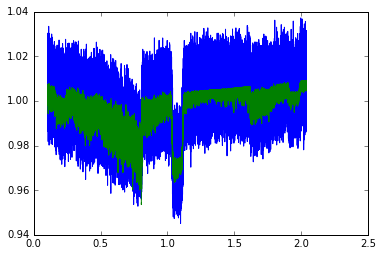

In [54]:
plt.plot(time_full, flux_clean)
plt.plot(time_full, lc_full*det_full)

plt.ylim(0.94, 1.04)


# Corner Plots

In [55]:
fig = corner.corner(samples[:,0:11], labels=["$t_0$","$R_p/R_*$", "$a/R_*$", "$i$",
                                             "$e \cos(\omega)$", "$e \sin(\omega)$", 
                                             "$q_1$", "$q_2$", "$f_p$", '$A$', '$B$'], 
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plotname = foldername + '/MCMC_Poly3_3.pdf'
fig.savefig(plotname, bbox_inches='tight')

# Diagnostics with Residuals

In [56]:
e_chain = np.sqrt(samples[:,4]**2 + samples[:,5]**2)
w_chain = np.arctan(samples[:,5]/samples[:,4])
u1_chain = 2*np.sqrt(samples[:,6]**2)*samples[:,7]
u2_chain = np.sqrt(samples[:,6]**2)*(1-2*samples[:,7])
binse = np.linspace(np.min(e_chain), np.max(e_chain), 20)
binsw = np.linspace(np.min(w_chain), np.max(w_chain), 20)
binsu1 = np.linspace(np.min(u1_chain), np.max(u1_chain), 20)
binsu2 = np.linspace(np.min(u2_chain), np.max(u2_chain), 20)

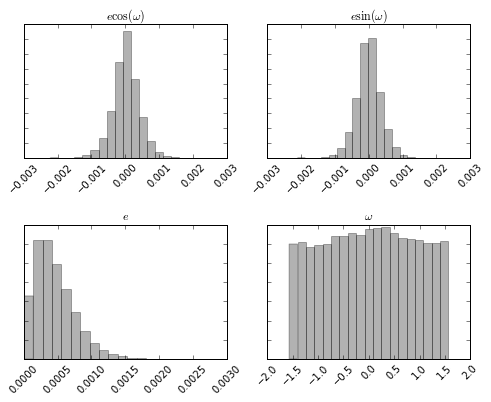

In [57]:
'''Eccentricity and Longitude of Periastron Coefficient'''
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
axes[0,0].hist(samples[:,4], bins=np.linspace(np.min(samples[:,4]), np.max(samples[:,4]), 20), color='k', alpha=0.3)
axes[0,1].hist(samples[:,5], bins=np.linspace(np.min(samples[:,5]), np.max(samples[:,4]), 20), color='k', alpha=0.3)
axes[1,0].hist(e_chain, binse, color='k', alpha=0.3)
axes[1,1].hist(w_chain, binsw, color='k', alpha=0.3)

plt.setp(axes[0,0].get_yticklabels(), visible=False)
plt.setp(axes[0,1].get_yticklabels(), visible=False)
plt.setp(axes[1,0].get_yticklabels(), visible=False)
plt.setp(axes[1,1].get_yticklabels(), visible=False)

plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

axes[0,0].set_title('$e \cos (\omega)$', fontsize=12)
axes[0,1].set_title('$e \sin (\omega)$', fontsize=12)
axes[1,0].set_title('$e$', fontsize=12)
axes[1,1].set_title('$\omega$', fontsize=12)

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.2)
plotname = foldername + '/MCMC_Poly3_5.pdf'
fig.savefig(plotname, bbox_inches='tight')

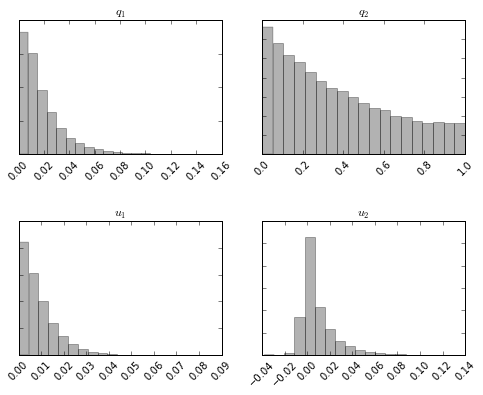

In [58]:
'''Eccentricity and Longitude of Periastron Coefficient'''
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
axes[0,0].hist(samples[:,6], bins=np.linspace(np.min(samples[:,6]), np.max(samples[:,6]), 20), color='k', alpha=0.3)
axes[0,1].hist(samples[:,7], bins=np.linspace(np.min(samples[:,7]), np.max(samples[:,7]), 20), color='k', alpha=0.3)
axes[1,0].hist(u1_chain, binsu1, color='k', alpha=0.3)
axes[1,1].hist(u2_chain, binsu2, color='k', alpha=0.3)

plt.setp(axes[0,0].get_yticklabels(), visible=False)
plt.setp(axes[0,1].get_yticklabels(), visible=False)
plt.setp(axes[1,0].get_yticklabels(), visible=False)
plt.setp(axes[1,1].get_yticklabels(), visible=False)

plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

axes[0,0].set_title('$q_1$', fontsize=12)
axes[0,1].set_title('$q_2$', fontsize=12)
axes[1,0].set_title('$u_1$', fontsize=12)
axes[1,1].set_title('$u_2$', fontsize=12)

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.2)
plotname = foldername + '/MCMC_Poly3_6.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [59]:
def triangle_colors(data1, data2, data3, data4, bins, res, label):
    fig = plt.figure(figsize = (8,8))
    gs  = gridspec.GridSpec(len(data1)-1,len(data1)-1)
    i = 0
    for k in range(np.sum(np.arange(len(data1)))):
        j= k - np.sum(np.arange(i+1))
        ax = fig.add_subplot(gs[i,j])
        ax.plot(data1[j], data1[i+1],'k.', markersize = 0.5)
        l1 = ax.plot(data2[j], data2[i+1],'.', color = '#66ccff', markersize = 0.7, label='$1^{st}$ secondary eclipse')
        l2 = ax.plot(data3[j], data3[i+1],'.', color = '#ff9933', markersize = 0.7, label='transit')
        l3 = ax.plot(data4[j], data4[i+1],'.', color = '#0066ff', markersize = 0.7, label='$2^{nd}$ secondary eclipse')
        if (j == 0):
            plt.setp(ax.get_yticklabels(), rotation = 45)
            ax.yaxis.set_major_locator(MaxNLocator(5, prune = 'both'))
            ax.set_ylabel(label[i+1])
        else:
            plt.setp(ax.get_yticklabels(), visible=False)
        if (i == len(data1)-2):
            plt.setp(ax.get_xticklabels(), rotation = 45)
            ax.plot(bins[j], res[j], '.', color='#ff5050', markersize = 3)
            ax.xaxis.set_major_locator(MaxNLocator(5, prune = 'both'))
            ax.set_xlabel(label[j])
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
        if(i == j):
            i += 1
    handles = [l1,l2,l3]
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0)
    #fig.legend(handles, ['$1^{st}$ secondary eclipse', 'transit', '$2^{nd}$ secondary eclipse'],bbox_to_anchor = [0.5, -0.05], loc = 'upper center')
    plotname = foldername + '/MCMC_Poly3_4.pdf'
    fig.savefig(plotname, bbox_inches='tight')
    #fig.colorbar()

In [60]:
test = ideal_lightcurve2(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], 
                                   inc_mcmc[0], ecosw_mcmc[0], esinw_mcmc[0], q1_mcmc[0], q2_mcmc[0], 
                                   fp_mcmc[0], 0, 0)
index = np.where(test != np.max(test))
ind_ecl1 = np.array([34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97])
ind_ecl2 = np.array([614,  615,
        616,  617,  618,  619,  620,  621,  622,  623,  624,  625,  626,
        627,  628,  629,  630,  631,  632,  633,  634,  635,  636,  637,
        638,  639,  640,  641,  642,  643,  644,  645,  646,  647,  648,
        649,  650,  651,  652,  653,  654,  655,  656,  657,  658,  659,
        660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,
        671,  672,  673,  674,  675,  676,  677])
ind_tra = np.array([1195, 1196, 1197, 1198,
       1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209,
       1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220,
       1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231,
       1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242,
       1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253,
       1254, 1255, 1256, 1257])

In [61]:
residual = flux/res_det - res_lightcurve
def binning_data(data, size):
    data = np.ma.masked_invalid(data) 
    reshaped_data   = data.reshape((len(data)/size, size))
    binned_data     = np.ma.median(reshaped_data, axis=1)
    binned_data_std = np.std(reshaped_data, axis=1)
    return binned_data

In [62]:
residual = flux/res_det - res_lightcurve

bin_x2, res_x2 = binning_data(xdata[:1350], 28), binning_data(residual[:1350],28)
bin_y2, res_y2 = binning_data(ydata[:1350], 28), binning_data(residual[:1350],28)
bin_sx2, res_sx2 = binning_data(psfxw[:1350], 28), binning_data(residual[:1350],28)
bin_sy2, res_sy2 = binning_data(psfyw[:1350],28), binning_data(residual[:1350],28)
bin_f2, res_f2 = binning_data(flux[:1350], 28), binning_data(residual[:1350],28)

res_bin2 = [res_x2, res_y2, res_sx2, res_sy2, res_f2]
bins2    = [bin_x2, bin_y2, bin_sx2, bin_sy2, bin_f2]

C:\Users\Lisa\Anaconda3\lib\site-packages\numpy\ma\core.py:4474: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = self._data.reshape(*s, **kwargs).view(type(self))
C:\Users\Lisa\Anaconda3\lib\site-packages\numpy\ma\core.py:4478: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result._mask = mask.reshape(*s, **kwargs)


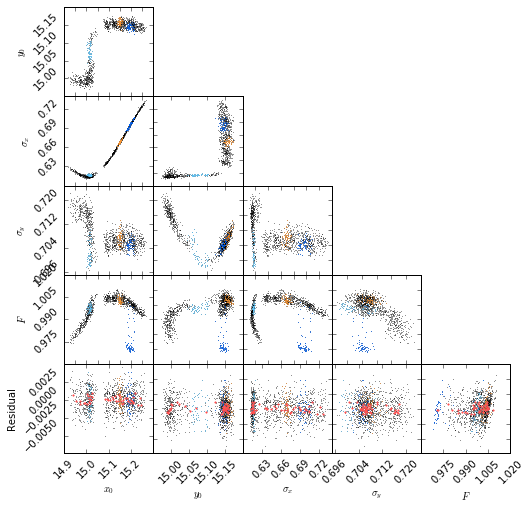

In [63]:
data1 = [xdata, ydata, psfxw, psfyw, flux, residual]
data2 = [xdata[ind_ecl1], ydata[ind_ecl1], psfxw[ind_ecl1], psfyw[ind_ecl1], flux[ind_ecl1], residual[ind_ecl1]]
data3 = [xdata[ind_tra], ydata[ind_tra], psfxw[ind_tra], psfyw[ind_tra], flux[ind_tra], residual[ind_tra]]
data4 = [xdata[ind_ecl2], ydata[ind_ecl2], psfxw[ind_ecl2], psfyw[ind_ecl2], flux[ind_ecl2], residual[ind_ecl2]]
label = ['$x_0$', '$y_0$', '$\sigma _x$', '$\sigma _y$', '$F$', 'Residual']

triangle_colors(data1, data2, data3, data4, bins2, res_bin2, label)

In [64]:
ResultMCMC_Params = Table()
ResultMCMC_Params['t0'] = [t0_mcmc]
#ResultMCMC_Params['per'] =[ per_mcmc]
ResultMCMC_Params['rp'] = [rp_mcmc]
ResultMCMC_Params['a'] = [a_mcmc] 
ResultMCMC_Params['inc'] = [inc_mcmc]
ResultMCMC_Params['ecosw'] = [ecosw_mcmc]
ResultMCMC_Params['esinw'] = [esinw_mcmc]
ResultMCMC_Params['q1'] = [q1_mcmc]
ResultMCMC_Params['q2'] = [q2_mcmc]
ResultMCMC_Params['fp'] = [fp_mcmc]

ResultMCMC_Params['A'] = [A_mcmc]
ResultMCMC_Params['B'] = [B_mcmc]

ResultMCMC_Params['c1'] = [c1_mcmc]
ResultMCMC_Params['c2'] = [c2_mcmc]
ResultMCMC_Params['c3'] = [c3_mcmc]
ResultMCMC_Params['c4'] = [c4_mcmc]
ResultMCMC_Params['c5'] = [c5_mcmc]
ResultMCMC_Params['c6'] = [c6_mcmc]
ResultMCMC_Params['c7'] = [c7_mcmc]
ResultMCMC_Params['c8'] = [c8_mcmc]
ResultMCMC_Params['c9'] = [c9_mcmc]
ResultMCMC_Params['c10'] = [c10_mcmc]

ResultMCMC_Params['sigF'] = [sigF_mcmc]

ResultMCMC_Params['chi2B'] = [chisB]
ResultMCMC_Params['logLB'] = [logLB]
ResultMCMC_Params['evidenceB'] = [EB]

ResultMCMC_Params['chi2'] = [chis]
ResultMCMC_Params['logL'] = [logL]
ResultMCMC_Params['evidence'] = [E]

pathres = foldername + '/ResultMCMC_Poly3_Params.npy'
np.save(pathres, ResultMCMC_Params)